In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

2024-11-04 17:34:53.220837: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730730893.235036   12317 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730730893.238625   12317 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-04 17:34:53.252673: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
dataset_path='rps-cv-images'
images=[]
labels=[]
for subfolder in os.listdir(dataset_path):
    subfolder_path = os.path.join(dataset_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue
    # Loop over the images in the subfolder
    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
        labels.append(subfolder)
        
df = pd.DataFrame({'image': images, 'label': labels})


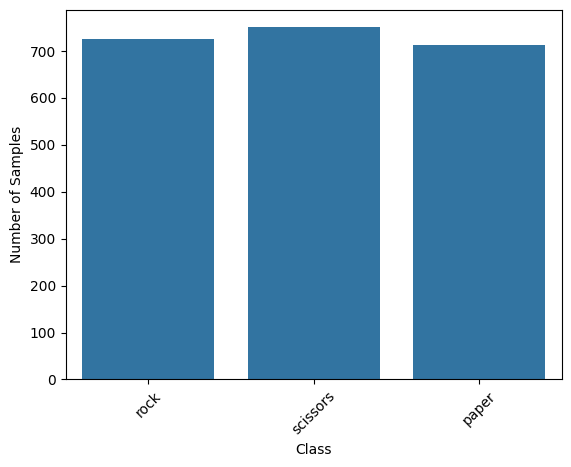

In [3]:
ax = sns.countplot(x=df.label)
ax.set_xlabel("Class")
ax.set_ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()

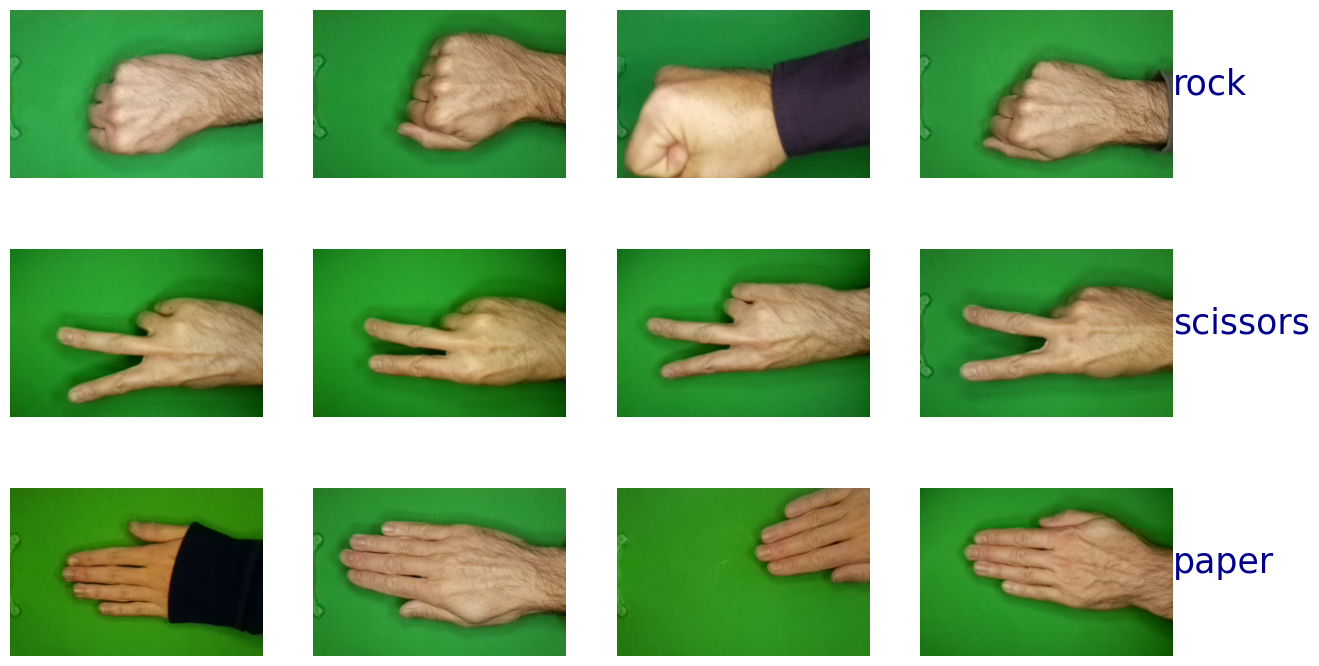

In [4]:
fig = plt.figure(figsize=(15, 15))
gs = GridSpec(5, 4, figure=fig)

# Loop through each unique category in the DataFrame
for i, category in enumerate(df['label'].unique()):
    filepaths = df[df['label'] == category]['image'].values[:4]
    for j, filepath in enumerate(filepaths):
        ax = fig.add_subplot(gs[i, j])
        ax.imshow(plt.imread(filepath))
        ax.axis('off')
    ax.text(300, 100, category, fontsize=25, color='darkblue')
plt.show()

In [5]:
X_train, X_val,y_train, y_val = train_test_split(df['image'], df['label'], test_size=0.4, random_state=42)

In [6]:
encoder=LabelEncoder()
y_train=encoder.fit_transform(y_train)
df_train = pd.DataFrame({'image': X_train, 'label': y_train})
df_val = pd.DataFrame({'image': X_val, 'label': y_val})

In [7]:
df_train['label'] = df_train['label'].astype(str)
df_val['label'] = df_val['label'].astype(str)

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale=1./255)

# Create generator for train and val data
train = train_datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=(50, 50),
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

val = val_datagen.flow_from_dataframe(
    df_val,
    x_col='image',
    y_col='label',
    target_size=(50, 50),
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

Found 1312 validated image filenames belonging to 3 classes.
Found 876 validated image filenames belonging to 3 classes.


In [9]:
model=Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(3, activation='softmax')
])

I0000 00:00:1730730896.954478   12317 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3588 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath='model.keras', save_best_only=True,verbose=2, monitor='val_accuracy')]

In [13]:
history=model.fit(train, validation_data=val, epochs=10, callbacks=callbacks)

Epoch 1/10


I0000 00:00:1730730972.125419   12423 service.cc:148] XLA service 0x7f257c005130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730730972.131771   12423 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-11-04 17:36:12.180029: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1730730972.352108   12423 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/21 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.2778 - loss: 1.1018

I0000 00:00:1730730977.450390   12423 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.3969 - loss: 1.0745
Epoch 1: val_accuracy improved from -inf to 0.67694, saving model to model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 414ms/step - accuracy: 0.4036 - loss: 1.0689 - val_accuracy: 0.6769 - val_loss: 0.6481
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.6369 - loss: 0.7683
Epoch 2: val_accuracy improved from 0.67694 to 0.91438, saving model to model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 0.6379 - loss: 0.7679 - val_accuracy: 0.9144 - val_loss: 0.3783
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.7934 - loss: 0.5508
Epoch 3: val_accuracy improved from 0.91438 to 0.94635, saving model to model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.7931 - loss: 0.5504 - val_accuracy: 0.9463 - val_loss: 0.2505
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8033 - loss: 0.4886
Epoch 4: val_accuracy did not improve from 0.94635
21/21 ━━━━━━━━━

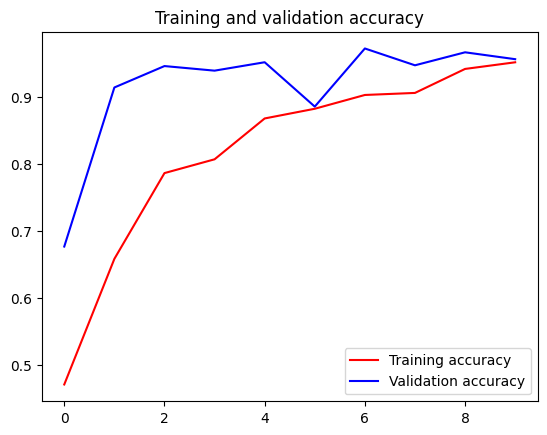

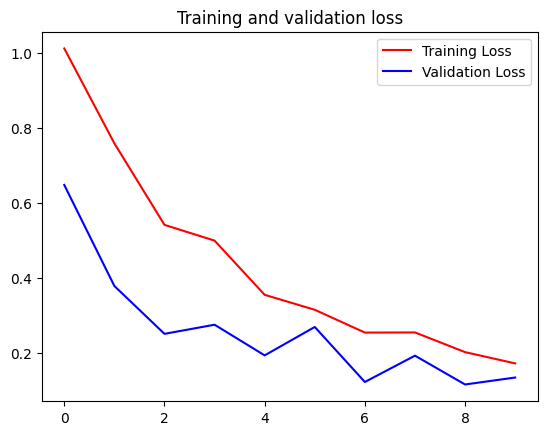

<Figure size 640x480 with 0 Axes>

In [15]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
#plot the predictions
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt

def predict_image(image_path):
    img = image.load_img(image_path, target_size=(50, 50))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img/255

    prediction = model.predict(img)
    prediction = np.argmax(prediction, axis=1)
    return encoder.inverse_transform(prediction)[0]

image_path = 'rps-cv-images/rock/2UaJz6Z3xJv3WX9h.png'
print(predict_image(image_path))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
rock


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


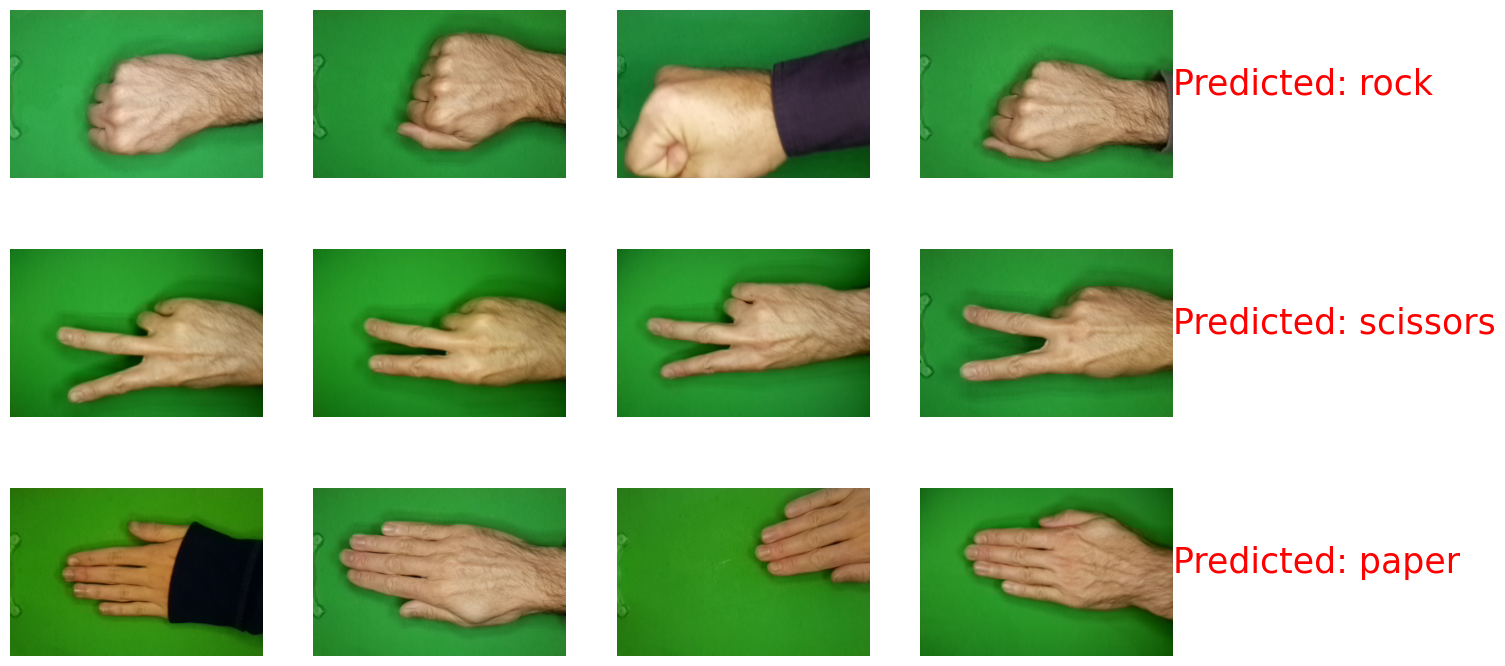

In [38]:
fig = plt.figure(figsize=(15, 15))
gs = GridSpec(5, 4, figure=fig)

# Loop through each unique category in the DataFrame
for i, category in enumerate(df['label'].unique()):
    filepaths = df[df['label'] == category]['image'].values[:4]
    for j, filepath in enumerate(filepaths):
        ax = fig.add_subplot(gs[i, j])
        ax.imshow(plt.imread(filepath))
        ax.axis('off')
    ax.text(300, 100, f"Predicted: {predict_image(filepath)}", fontsize=25, color='red')
plt.show()